# Risk and Revenue prediction in oil industry

Let's say you work for the production company GlavRosGosNeft. You need to decide where to drill the new oil well.

You have been provided with oil samples in three regions: in each of 10,000 fields, where the quality of oil and the volume of its reserves were measured. Build a machine learning model to help determine the region where mining will generate the most profit. Analyze potential rewards and risks with *Bootstrap* technique.

Steps for choosing a location:

- Deposits are searched for in the selected region, and the values of the attributes are determined for each
- Build a model and estimate the volume of reserves
- Select deposits with the highest value estimates. The number of fields depends on the company's budget and the cost of developing one oil well
- The profit is equal to the total profit of the selected fields

## Data Description
Geological prospecting data for three regions are in files:
* geo_data_0.csv
* geo_data_1.csv
* geo_data_2.csv 

Columns:
* id - unique identifier of the oil well
* f0, f1, f2 - three features of points (it doesn't matter what they mean, but the features themselves are significant)
* product - the volume of oil reserves in the well (thousand barrels)

## Project goals
* determine the region for the development of oil extraction points with the highest profit
* the probability of losses should not exceed 2.5%
* the budget for the development of new oil extraction points should be taken into account

# Table of Content <a id='content'></a>

[**1. Loading and preparing data**](#step1)
   * [*1.1 Data import and overview of general information*](#step1.1)
   * [*1.2 Missing values*](#step1.2)
   * [*1.3 Duplicates*](#step1.3)
   * [*1.4 Checking for multicollinearity*](#step1.4)
   * [*1.5 Check for anomalies*](#step1.5)

[**2. Train and validate ML model**](#step2)
   * [*2.1 Creation of training and test samples*](#step2.1)
   * [*2.2 Region 1*](#step2.2)
   * [*2.3 Region 2*](#step2.3)
   * [*2.4 Region 3*](#step2.4)
   * [*2.5 Summary*](#step2.5)
   
[**3. Preparation for calculating revenue**](#step3)

[**4. Calculation of profit and risk**](#step4)
   * [*4.1 Profit comparison: reality vs predictions*](#step4.1)
   * [*4.2 Risk calculation*](#step4.2)

[**5. Summary**](#step5)

# 1. Loading and preparing data <a class="anchor" id="step1"></a>
[back to content](#content)

Importing libraries:

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Procedure for preparing data:
* data import, general information
* dealing with missing values
* handling duplicates
* check for multicollinearity
* check for anomalies
* data normalization (scaling)

## 1.1 Data import and overview of general information <a class="anchor" id="step1.1"></a>
[back to content](#content)

In [3]:
df_0 = pd.read_csv('geo_data_0.csv')
df_1 = pd.read_csv('geo_data_1.csv')
df_2 = pd.read_csv('geo_data_2.csv')

In [4]:
print('First region dataset size:: {} rows and {} columns.'.format(df_0.shape[0], df_0.shape[1]))
print('Second region dataset size:: {} rows and {} columns.'.format(df_1.shape[0], df_1.shape[1]))
print('Third region dataset size:: {} rows and {} columns.'.format(df_2.shape[0], df_2.shape[1]))

First region dataset size:: 100000 rows and 5 columns.
Second region dataset size:: 100000 rows and 5 columns.
Third region dataset size:: 100000 rows and 5 columns.


Let's look at the dataframes:

In [5]:
df_0.sample(3)

,id,f0,f1,f2,product
25528,JIQLJ,0.242226,-0.132629,4.488458,56.226992
59918,K6Igd,0.848227,-0.408035,-1.238680,105.772560
11118,vvkHU,-0.631960,0.983926,0.495544,127.457780


In [6]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df_1.sample(3)

,id,f0,f1,f2,product
92112,y5Y1F,-11.235986,-3.415770,3.015676,84.038886
92054,tUlne,12.920292,5.571968,2.996634,80.859783
9280,gAIj8,-6.498861,-9.510262,4.005192,110.992147


In [8]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
df_2.sample(3)

,id,f0,f1,f2,product
45968,iawOk,1.649083,-0.746671,1.805208,109.383043
92884,t0RGQ,-1.215989,0.841644,3.245564,30.032834
72139,i5ojJ,-1.064315,-0.745902,-0.359383,6.024898


In [10]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


## 1.2 Missing values <a class="anchor" id="step1.2"></a>

There are no missing values.

## 1.3 Duplicates <a class="anchor" id="step1.3"></a>
[back to content](#content)

In [11]:
df_0.duplicated().sum()

0

In [12]:
df_1.duplicated().sum()

0

In [13]:
df_2.duplicated().sum()

0

There are no duplicates.

## 1.4 Checking for multicollinearity <a class="anchor" id="step1.4"></a>
[back to content](#content)

In [14]:
#columns with features
feature_cols = ['f0', 'f1', 'f2']

Text(0.5, 1.0, 'Correlation matrix for region 1')

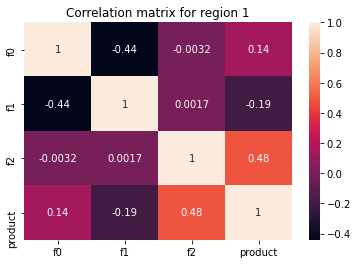

In [15]:
sns.heatmap(df_0.corr(), annot=True)
plt.title('Correlation matrix for region 1')

Text(0.5, 1.0, 'Correlation matrix for region 2')

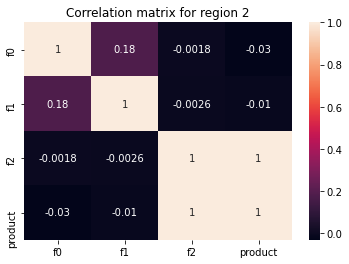

In [16]:
sns.heatmap(df_1.corr(), annot=True)
plt.title('Correlation matrix for region 2')

Text(0.5, 1.0, 'Correlation matrix for region 3')

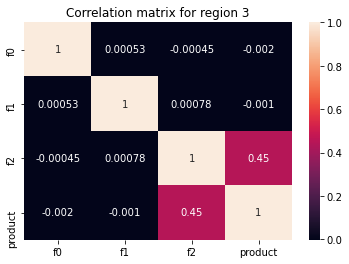

In [17]:
sns.heatmap(df_2.corr(), annot=True)
plt.title('Correlation matrix for region 3')

In region 2, there is a very strong correlation between the target and *f2* feature. But since all the parameters are very significant for the characteristics of the oil extraction points, we will not delete it.

## 1.5 Check for anomalies <a class="anchor" id="step1.5"></a>
[back to content](#content)

Let's look at the distributions of the data using the scatter matrix.

Text(0.5, 1.0, 'Region 1')

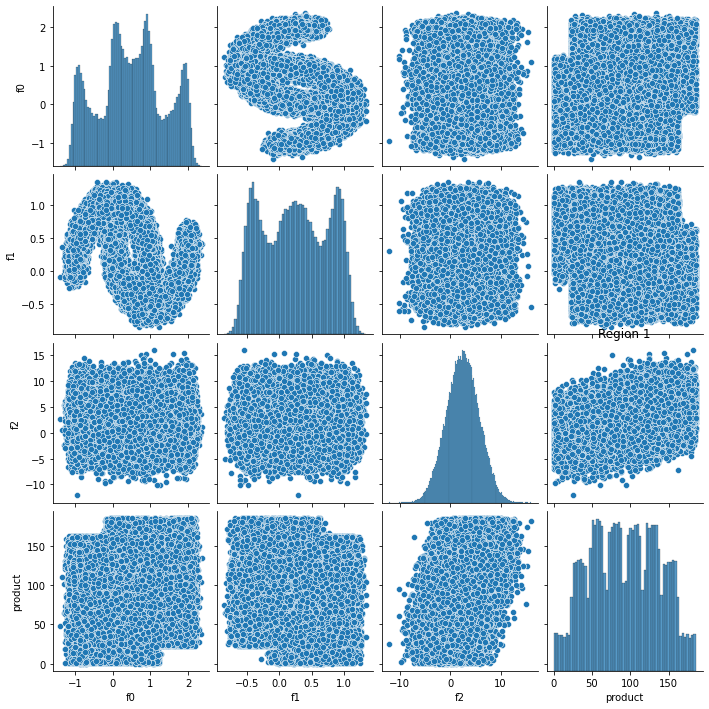

In [18]:
sns.pairplot(df_0.drop('id', axis=1))
plt.title('Region 1')

Text(0.5, 1.0, 'Region 2')

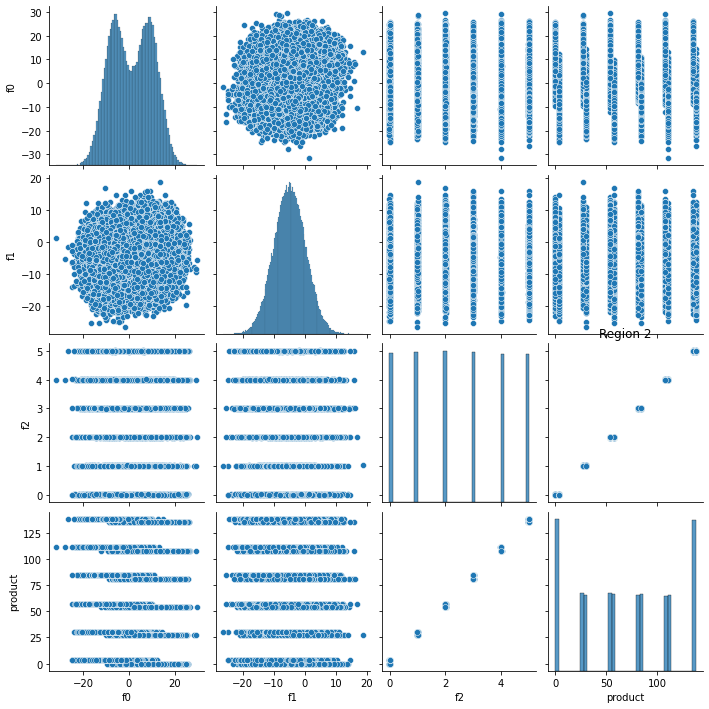

In [19]:
sns.pairplot(df_1.drop('id', axis=1))
plt.title('Region 2')

Text(0.5, 1.0, 'Region 3')

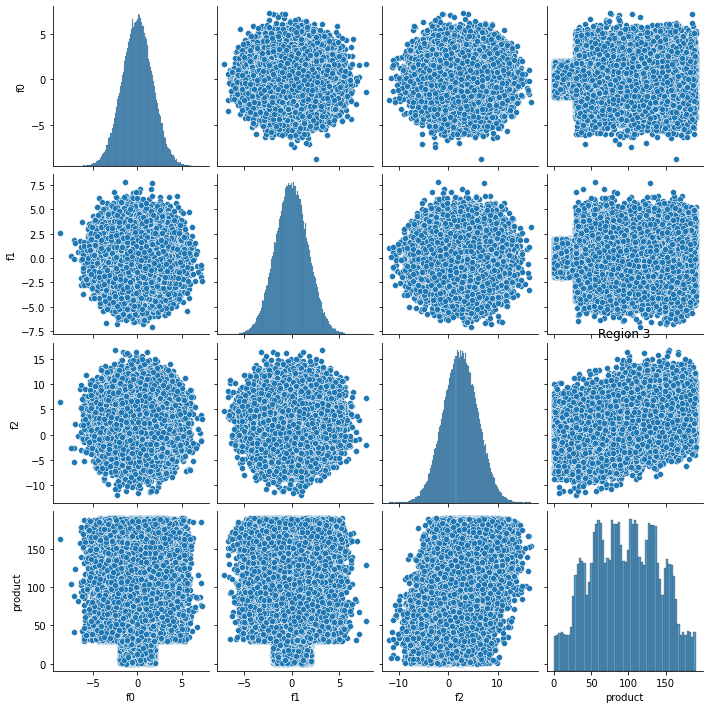

In [20]:
sns.pairplot(df_2.drop('id', axis=1))
plt.title('Region 3')

The dataset from the second region is definitely highlighted. There, the amount of product in almost all oil oil extraction points is the same. If we discard the extreme values, then we can get the same amount of oil in all places.

# 2. Train and validate ML model <a class="anchor" id="step2"></a>
[back to content](#content)

## 2.1 Creation of training and test samples <a class="anchor" id="step2.1"></a>
[back to content](#content)

Let's divide the initial data into two samples with sizes:
* training: 75%
* validation: 25%

Let's set the parameter *random_state* for repeatable results and will use it constantly.

In [21]:
random_state = 666

In [22]:
# function for automatically splitting data into training and test samples
def split_data(df, test_size, features, target):
    df_train, df_valid = train_test_split(df,test_size=test_size,
                                          random_state=random_state,
                                          shuffle=True)

    features_train = df_train[features]
    target_train = df_train[target]
    features_valid =df_valid[features]
    target_valid = df_valid[target]
    
    return features_train, target_train, features_valid, target_valid

In [23]:
# get samples for region 1
features_train_0, target_train_0, features_valid_0, target_valid_0 = split_data(
    df_0, 0.25, feature_cols, 'product')

In [24]:
#посмотрим на размеры полученных датафреймов
print('Size of training dataset: {}'.format(features_train_0.shape))
print('Size of validation dataset: {}'.format(features_valid_0.shape))

Size of training dataset: (75000, 3)
Size of validation dataset: (25000, 3)


In [25]:
# get samples for region 2, leave the feature with high correlation f2
features_train_1, target_train_1, features_valid_1, target_valid_1 = split_data(
    df_1, 0.25, feature_cols, 'product')

In [26]:
# get samples for region 3
features_train_2, target_train_2, features_valid_2, target_valid_2 = split_data(
    df_2, 0.25, feature_cols, 'product')

## 2.2 Region 1 <a class="anchor" id="step2.2"></a>
[back to content](#content)

We will use linear regression for training.

In [27]:
# train the model and save the predictions
model_0 = LinearRegression().fit(features_train_0, target_train_0)
predictions_0 = model_0.predict(features_valid_0)

In [28]:
#function for calculating model metrics and average stock of raw materials in predictions
def evaluate_model(model, features_valid, target_valid):
    predictions = model.predict(features_valid)
    rmse = np.round(mean_squared_error(target_valid, predictions) ** 0.5, 4)
    r2 = np.round(model.score(features_valid, target_valid), 4)
    
    mean_reserve = np.round(np.mean(predictions),4)
    
    return predictions, rmse, r2, mean_reserve 

In [29]:
# function for displaying metrics
# abbriviation for thousand barrells: Mbbl
def print_metrics(region, rmse, r2, mean_reserve):
    print('Model metrics for {}'.format(region))
    print('RMSE: {} | R2: {} | average amount of predicted oil reserve: {} {}'.format(
        rmse, r2, mean_reserve, '[Mbbl]'))

Let's calculate the model metrics:

In [30]:
predictions_0, rmse_0, r2_0, mean_est_reserve_0 = evaluate_model(model_0, features_valid_0, target_valid_0)
print_metrics('Region 1', rmse_0, r2_0, mean_est_reserve_0)

Model metrics for Region 1
RMSE: 37.7885 | R2: 0.2738 | average amount of predicted oil reserve: 92.5988 [Mbbl]


In [31]:
#function for visualizing regression
def plot_regression(predictions, target, title=None):
    ax = sns.regplot(x=predictions, y=target, color="g")
    ax.set(xlabel='predictions', ylabel='target', title=title)

Let's look at the predictions of the model and the target admit on the scatterplot:

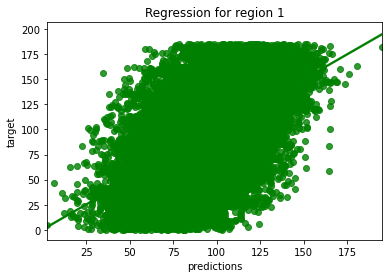

In [32]:
plot_regression(predictions_0, target_valid_0, title='Regression for region 1')

Quite a large scatter of values between the target feature and the model predictions (low R2).

## 2.3 Region 2 <a class="anchor" id="step2.3"></a>
[back to content](#content)

In [33]:
#train the model and save the predictions
model_1 = LinearRegression().fit(features_train_1, target_train_1)
predictions_1 = model_1.predict(features_valid_1)

Let's calculate the model metrics:

In [34]:
predictions_1, rmse_1, r2_1, mean_est_reserve_1 = evaluate_model(model_1, features_valid_1, target_valid_1)
print_metrics('Region 2', rmse_1, r2_1, mean_est_reserve_1)

Model metrics for Region 2
RMSE: 0.8899 | R2: 0.9996 | average amount of predicted oil reserve: 69.1196 [Mbbl]


Let's look at the predictions of the model and the target admit on the scatterplot:

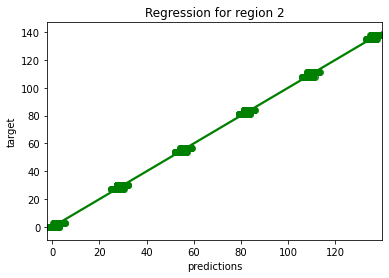

In [35]:
plot_regression(predictions_1, target_valid_1, title='Regression for region 2')

The scores are very high due to the presence of a feature (f2) that is highly correlated with the target.

## 2.4 Region 3 <a class="anchor" id="step2.4"></a>
[back to content](#content)

In [36]:
# train the model and save the predictions
model_2 = LinearRegression().fit(features_train_2, target_train_2)
predictions_2 = model_2.predict(features_valid_2)

Let's calculate the model metrics:

In [37]:
predictions_2, rmse_2, r2_2, mean_est_reserve_2 = evaluate_model(model_2, features_valid_2, target_valid_2)
print_metrics('Region 3', rmse_2, r2_2, mean_est_reserve_2)

Model metrics for Region 3
RMSE: 40.0086 | R2: 0.1934 | average amount of predicted oil reserve: 95.0583 [Mbbl]


Посмотрим на предсказания модели и целевой признай на диаграмме рассеяния:

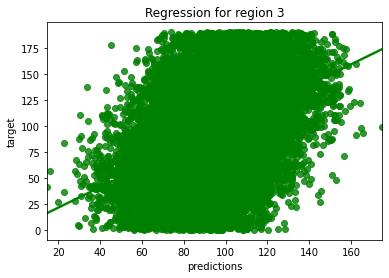

In [38]:
plot_regression(predictions_2, target_valid_2, title='Regression for region 3')

Similar results with the first region. The average stock of predicted raw materials is higher, but the spread is wider.

## 2.5 Summary <a class="anchor" id="step2.5"></a>
[back to content](#content)

In [39]:
# real average oil reserves in regions
mean_real_reserve_0 = np.round(np.mean(df_0['product']),4)
mean_real_reserve_1 = np.round(np.mean(df_1['product']),4)
mean_real_reserve_2 = np.round(np.mean(df_2['product']),4)

In [40]:
#create a pivot table with the results of training models by region
models_results = pd.DataFrame(
    {'Region': [1,2,3],
     'RMSE':[rmse_0, rmse_1, rmse_2],
     'R2':[r2_0, r2_1, r2_2],
     'average amount of predicted oil reserve [Mbbl]':
     [mean_est_reserve_0, mean_est_reserve_1, mean_est_reserve_2],
     'real average amount of oil reserve [Mbbl]':
     [mean_real_reserve_0, mean_real_reserve_1, mean_real_reserve_2]}).sort_values(by='average amount of predicted oil reserve [Mbbl]',
                                                                                   ascending=False)

models_results_melt = models_results.melt(id_vars='Region').loc[6:]

Have a look at model metrics for all regions:

In [41]:
models_results.style.background_gradient(
    cmap='coolwarm',subset='average amount of predicted oil reserve [Mbbl]')

,Region,RMSE,R2,average amount of predicted oil reserve [Mbbl],real average amount of oil reserve [Mbbl]
2,3,40.008600,0.193400,95.058300,95.000000
0,1,37.788500,0.273800,92.598800,92.500000
1,2,0.889900,0.999600,69.119600,68.825000


At the moment, regions 1 and 3 seem to be the most promising.

# 3. Preparation for calculating revenue <a class="anchor" id="step3"></a>
[back to content](#content)

Let's prepare variables for calculating revenue:

In [42]:
# monetary units in billion rubles
budget = 10
barrel_price = 0.00045

# number of oil oil extraction points for development
holes_select_count = 200

#number of surveyed oil extraction points in the region
holes_inspect_count = 500

In [43]:
#sufficient volume of raw materials for breakeven development of a new oil extraction point
min_reserve =  np.round((budget/holes_select_count)/barrel_price, 3)
print('Min volume oil reserves for a profitable development of a new extraction point: {} [Mbbl]'.format(min_reserve))

Min volume oil reserves for a profitable development of a new extraction point: 111.111 [Mbbl]


Let's compare the minimum oil reserve for a profitable development with the average reserves of the extraction points:

Text(1, 95, 'break even point')

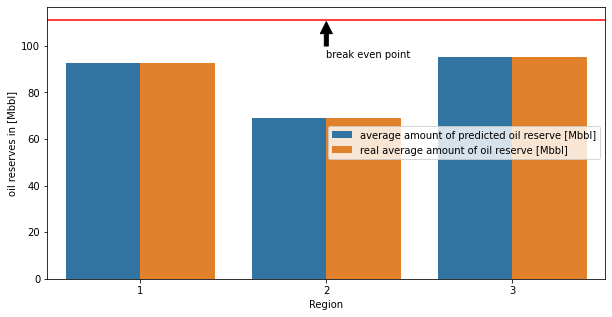

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(data=models_results_melt, x='Region', y='value', hue='variable')
plt.axhline(y=min_reserve, color='r', linestyle='-')
plt.legend(loc='center right')
plt.ylabel('oil reserves in [Mbbl]')
plt.annotate('break even point', xy=(1, 111), xytext=(1, 95), arrowprops=dict(facecolor='black', shrink=0.05))

**Conclusion:**
* for a break-even development of one extraction point, a minimum of 111.111 thousand barrels of raw material is required
* the average stock of raw materials is clearly not enough for profitable well development in any of the regions, you need to find the best ones

# 4. Calculation of profit and risk <a class="anchor" id="step4"></a>
[back to content](#content)

## 4.1 Profit comparison: reality vs predictions <a class="anchor" id="step4.1"></a>
[back to content](#content)

Let's create a function to calculate the profit for the wells selected by the model:

In [45]:
def calculate_revenue(budget, barrel_price, selected_holes):
    # returns profit in billion rubles (turnover minus budget)
    revenue = (selected_holes.sum() * barrel_price) - budget
    return np.round(revenue, 6)    

Let's select 200 extraction points from the model predictions with the maximum amount of oil:

In [46]:
best_predict_0 = pd.Series(predictions_0, index=target_valid_0.index).sort_values(ascending=False)[:holes_select_count]
best_predict_1 = pd.Series(predictions_1, index=target_valid_1.index).sort_values(ascending=False)[:holes_select_count]
best_predict_2 = pd.Series(predictions_2, index=target_valid_2.index).sort_values(ascending=False)[:holes_select_count]

Let's find these wells in the target feature:

In [47]:
target_predict_0 = target_valid_0[best_predict_0.index]
target_predict_1 = target_valid_1[best_predict_1.index]
target_predict_2 = target_valid_0[best_predict_2.index]

Let's create a pivot table where we will calculate the profit, as well as the real and predicted amount of oil reserves for the selected extraction points:

In [48]:
predict_target_compare = pd.DataFrame(
    {'Region': [1,1,2,2,3,3],
     'calculation':['real', 'prediction',
               'real', 'prediction',
               'real', 'prediction'],
     'amount of oil [Mbbl]':
     [target_predict_0.sum(),best_predict_0.sum(),
      target_predict_1.sum(),best_predict_1.sum(),
      target_predict_2.sum(),best_predict_2.sum()],
     'revenue [billion RUB]':
     [calculate_revenue(budget, barrel_price, target_predict_0),
      calculate_revenue(budget, barrel_price, best_predict_0),
      calculate_revenue(budget, barrel_price, target_predict_1),
      calculate_revenue(budget, barrel_price, best_predict_1),
      calculate_revenue(budget, barrel_price, target_predict_2),
      calculate_revenue(budget, barrel_price, best_predict_2)],
    }).sort_values(by='revenue [billion RUB]', ascending=False)

Let's compare the predicted and real profit for the selected oil fields:

Text(0.5, 1.0, 'Revenue comparison by regions: real vs prediction')

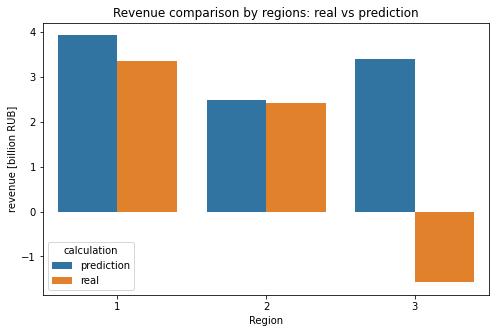

In [49]:
plt.figure(figsize=(8,5))
sns.barplot(data=predict_target_compare, x='Region', y='revenue [billion RUB]', hue='calculation')
plt.title('Revenue comparison by regions: real vs prediction')

Only for the first and second regions the predictions were close to reality. In the third region, instead of a loss, a large profit was predicted.

## 4.2 Risk calculation <a class="anchor" id="step4.2"></a>
[back to content](#content)

Let's apply Bootstrap's procedure for calculating risks and confidence intervals.

In [50]:
random_state = np.random.RandomState(666)

In [51]:
# function for bootstrap procedure, returns list of profit
def bootstrap_revenue(target_valid, predictions, sample_count, loops_count, holes_count):
    values = []
    for i in range(loops_count):
            target_subsample = target_valid.sample(n=sample_count,
                                           replace=True,
                                           random_state=random_state)
            predictions = pd.Series(predictions, index=target_valid.index)
            predict_subsample = predictions[target_subsample.index].sort_values(ascending=False)[:holes_count]
            values.append(calculate_revenue(budget, barrel_price, target_valid[predict_subsample.index]))
    
    return pd.Series(values)        

Let's find the distribution of profit for each region:

In [52]:
%%time
bootstrap_revenue_0 = bootstrap_revenue(target_valid_0, predictions_0, 500, 1000, 200)
bootstrap_revenue_1 = bootstrap_revenue(target_valid_1, predictions_1, 500, 1000, 200)
bootstrap_revenue_2 = bootstrap_revenue(target_valid_2, predictions_2, 500, 1000, 200)

CPU times: user 2.74 s, sys: 0 ns, total: 2.74 s
Wall time: 2.74 s


Let's look at the distribution of profit on the histogram. The red line marks the border of zero profit.

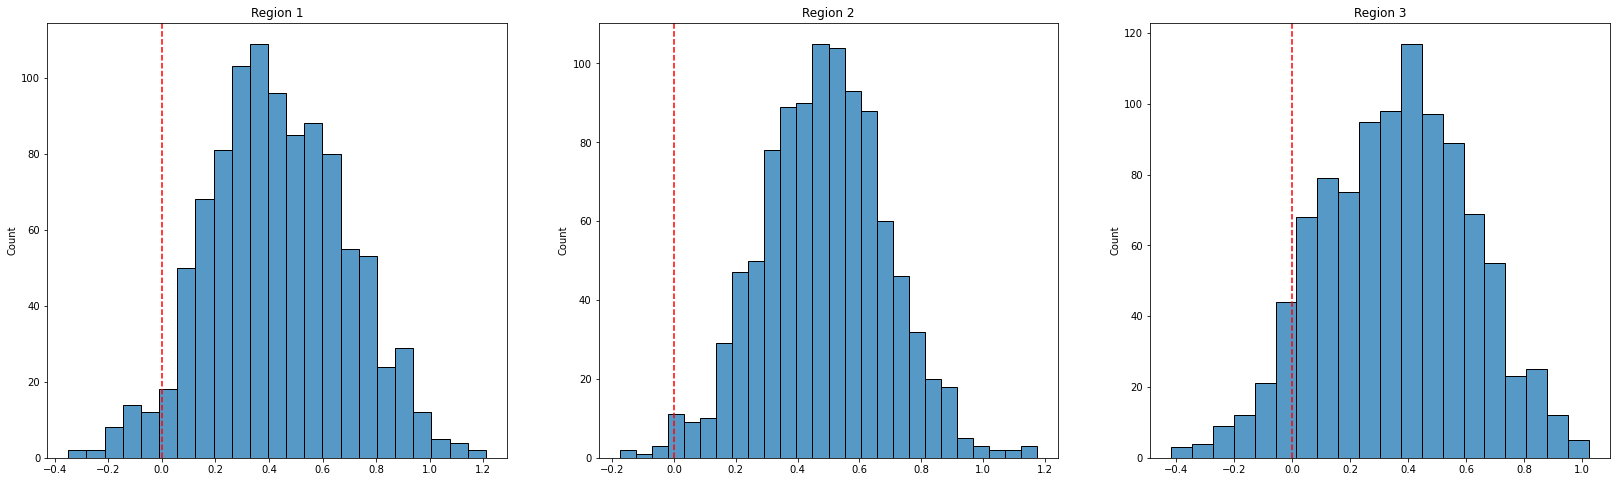

In [53]:
fig, axis = plt.subplots(ncols=3, nrows=1, figsize=(28, 8))
ax = axis.ravel()
sns.histplot(bootstrap_revenue_0, ax=ax[0])
sns.histplot(bootstrap_revenue_1, ax=ax[1])
sns.histplot(bootstrap_revenue_2, ax=ax[2])
ax[0].set_title('Region 1')
ax[1].set_title('Region 2')
ax[2].set_title('Region 3')
ax[0].axvline(0, color='r', ls='--')
ax[1].axvline(0, color='r', ls='--')
ax[2].axvline(0, color='r', ls='--')

Let's calculate the average profit, 95% confidence interval and risks of losses for each region:

In [54]:
#average profit
mean_revenue_0 = np.round(bootstrap_revenue_0.mean(), 6)
mean_revenue_1 = np.round(bootstrap_revenue_1.mean(), 6)
mean_revenue_2 = np.round(bootstrap_revenue_2.mean(), 6)

In [55]:
#borders of 95% confidence interval
revenue_conf_0_lower = bootstrap_revenue_0.quantile(0.025)
revenue_conf_0_upper = bootstrap_revenue_0.quantile(0.975)

revenue_conf_1_lower = bootstrap_revenue_1.quantile(0.025)
revenue_conf_1_upper = bootstrap_revenue_1.quantile(0.975)

revenue_conf_2_lower = bootstrap_revenue_2.quantile(0.025)
revenue_conf_2_upper = bootstrap_revenue_2.quantile(0.975)

In [56]:
#risks of loss (share of negative profit in the distribution)
risk_0 = np.round((len(bootstrap_revenue_0[bootstrap_revenue_0 < 0]) / len(bootstrap_revenue_0)), 4)
risk_1 = np.round((len(bootstrap_revenue_1[bootstrap_revenue_1 < 0]) / len(bootstrap_revenue_1)), 4)
risk_2 = np.round((len(bootstrap_revenue_2[bootstrap_revenue_2 < 0]) / len(bootstrap_revenue_2)), 4)

Let's collect all the indicators in one table:

In [57]:
risk_table = pd.DataFrame({'Region': [1,2,3],
                           'Average profit [billions RUB]':[mean_revenue_0, mean_revenue_1, mean_revenue_2],
                           'lower border of 95% conf. interv. [billions RUB]':
                           [revenue_conf_0_lower, revenue_conf_1_lower, revenue_conf_2_lower],
                           'upper border of 95% conf. interv. [billions RUB]':
                           [revenue_conf_0_upper, revenue_conf_1_upper, revenue_conf_2_upper],
                           'risk of losses':[risk_0, risk_1, risk_2]})

Let's see the results:

In [58]:
risk_table.style.format({'risk of losses': '{:,.1%}'}).background_gradient(cmap='coolwarm',
                                                                           subset='Average profit [billions RUB]')

,Region,Average profit [billions RUB],lower border of 95% conf. interv. [billions RUB],upper border of 95% conf. interv. [billions RUB],risk of losses
0,1,0.432464,-0.079795,0.933216,4.1%
1,2,0.485312,0.078851,0.871589,1.2%
2,3,0.357730,-0.148545,0.860627,7.8%


Text(1, 0.03, 'lowest risk')

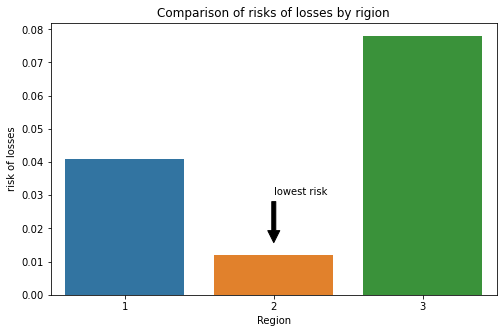

In [59]:
plt.figure(figsize=(8,5))
sns.barplot(data=risk_table, x='Region', y='risk of losses')
plt.title('Comparison of risks of losses by rigion')
plt.annotate('lowest risk', xy=(1, 0.015), xytext=(1, 0.03), arrowprops=dict(facecolor='black', shrink=0.05))

Text(1.5, 0.45, 'highest average revenue')

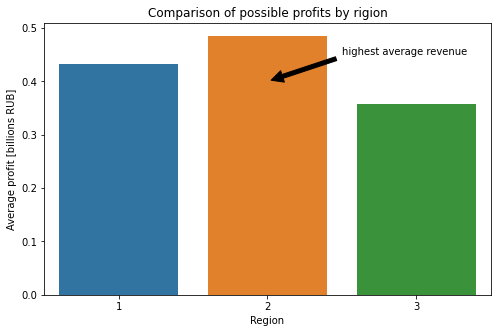

In [60]:
plt.figure(figsize=(8,5))
sns.barplot(data=risk_table, x='Region', y='Average profit [billions RUB]')
plt.title('Comparison of possible profits by rigion')
plt.annotate('highest average revenue',
             xy=(1.0, 0.4), xytext=(1.5, 0.45),
             arrowprops=dict(facecolor='black', shrink=0.05))

# 5.0 Summary <a class="anchor" id="step5"></a>
[back to content](#content)

* for the development of new oil fields the following region is proposed: **region 2**
* the second region showed the lowest risk of losses of 1.2%, as well as positive boundaries in the 95% confidence interval, which indicates a high probability of making a profit from oil extraction there
* although the average amount of raw materials is higher in other regions, nevertheless, statistically, making a profit there will be more risky